## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [ ]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:

def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128], l2_ratio = 0, use_bn = False, use_drop = False, drop_ratio = 0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, deep in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=deep, kernel_regularizer=keras.regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            if use_bn:
                x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            if use_drop:
                x = keras.layers.Dropout(drop_ratio)(x)

        else:
            x = keras.layers.Dense(units=deep, kernel_regularizer= keras.regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
            if use_drop:
                x = keras.layers.Dropout(drop_ratio)(x)

    out = keras.layers.Dense(units = output_units, activation= 'softmax' , name = 'output')(x)

    model = keras.models.Model(inputs=input_layer,outputs=out)
    
    return model

In [ ]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95

use_bn = [True,False]
use_drop = [True,False]
l2_ratio = [0,0.005]

In [ ]:
results = {}
"""Code Here
"""
for i, (bn, drop, l2_r) in enumerate(itertools.product(use_bn,use_drop,l2_ratio)):

    keras.backend.clear_session() #清除
    print(f"bn_{bn}* drop_{drop}* l2_{l2_r}")
    model = build_mlp(input_shape = x_train.shape[1:],use_bn=bn, use_drop=drop, l2_ratio=l2_r, drop_ratio=0.25)
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, momentum = MOMENTUM, nesterov = True)

    model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer = optimizer)
    model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_test,y_test), shuffle = True)

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    name_tag = f"bn_{bn}* drop_{drop}* l2_{l2_r}"
    results[name_tag] = {'train-loss': train_loss,
                        'valid-loss': valid_loss,
                        'train-acc': train_acc,
                        'valid-acc': valid_acc}

bn_True* drop_True* l2_0
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch 

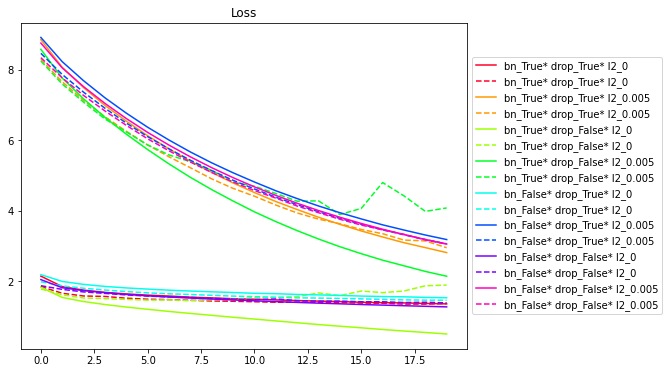

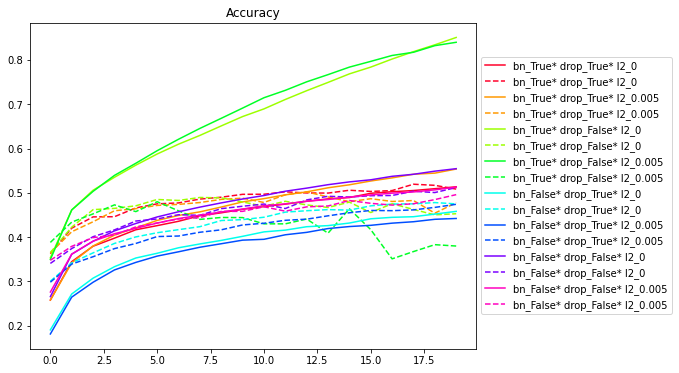

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 8

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 有做BN + 做Drop 無正規化者 效果較佳